In [1]:
import sys
import spotipy
import pandas as pd
import numpy as np
import matplotlib
import time
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.gridspec as gridspec
from scipy import interpolate

In [2]:
%matplotlib inline

In [290]:
from spotipy.oauth2 import SpotifyClientCredentials
client_credentials_manager = SpotifyClientCredentials(client_id=' ', client_secret=' ')

In [288]:
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

In [5]:
def getAudioFeatures(playlist):
    df = pd.DataFrame(columns=['name', 'danceability', 'energy', 'key', 'loudness',
                           'speechiness', 'acousticness', 'instrumentalness',
                           'liveness', 'valence', 'tempo', 'duration_ms'])
    
    tracks = playlist['items']

    while playlist['next']:
        playlist = sp.next(playlist)
        tracks.extend(playlist['items'])

    for i in range(0, len(tracks)):
        song_features = sp.audio_features(tracks[i]['track']['id'])[0]
        song_features['name'] = tracks[i]['track']['name']

        for key in df.keys():
            df.loc[i,key] = song_features[key]

    df['duration_min'] = df['duration_ms'] / 1000 / 60
    df = df.drop(columns=['duration_ms'])

    return df

In [6]:
like_df = getAudioFeatures(sp.user_playlist_tracks("1248025501", "6OADABzWPd8HgdVFli0NXB"))
print('like')
dislike_df = getAudioFeatures(sp.user_playlist_tracks("1248025501", "1AZxiL7LrFGT3PGoecDdpB"))
print('dislike')


dislike_df['like'] = 0
like_df['like'] = 1

print(like_df.shape)
print(dislike_df.shape)

like
dislike
(211, 13)
(150, 13)


In [7]:
rand_df = getAudioFeatures(sp.user_playlist_tracks("1248025501", "3gt9k1D9Hk4ABCIHfQhZL8"))
print('rand')
jp_df = getAudioFeatures(sp.user_playlist_tracks("1248025501", "1TEgN1E2KrhTgrq6zc9o3k"))
print('JP')
good_inst_df = getAudioFeatures(sp.user_playlist_tracks("1248025501", "2CGrG9oXvsUYZ0sav4nMTE"))
print('good inst')

rand
JP
good inst


In [107]:
def plotter(ax, key, bins, df, col, lab):
    bin_w = (bins[1] - bins[0]) / 2
    
    mean = sum(df[key]) / len(df[key])
    
    weights = np.ones_like(list(df[key]))/float(len(df[key]))
    
    hist = ax.hist(list(df[key]), bins, alpha=0.15, label=lab, color = col, weights = weights)
    
    xnew = np.arange(bins[0], bins[-2], 0.0001)
    ax.legend()
    ax.set_ylim(ymin = 0)
    ax.set_xlim(xmin=bins[0], xmax=bins[-1])

    if key == 'key':
        return hist[0].max()
    
    ax.axvline(x=mean, color = col, ls = '--')

    f = interpolate.interp1d(bins[0:len(bins) - 1] + bin_w, hist[0], bounds_error=False, kind ='quadratic')
    ynew = f(xnew)
    ax.plot(xnew, ynew, color = col)

    ax.set_title(key)
    
    return(hist[0].max())

In [9]:
filepath = '../aust427.github.io/images/data-products/spotify/'

In [212]:
def subplotPlot(df, col, lab):
    
    sub_dict = {'danceability': np.linspace(0, 1, 20), 
     'energy': np.linspace(0, 1, 20), 
     'loudness': np.linspace(-25, 0, 25),
     'acousticness': np.linspace(0, 1, 20), 
     'instrumentalness': np.linspace(0, 1, 20),
    'liveness': np.linspace(0, 1, 20), 
     'valence': np.linspace(0, 1, 20), 
     'tempo': np.linspace(50, 230, 20), 
     'duration_min': np.linspace(0, 12, 20)}

    fig, ax = plt.subplots(3, 3, figsize=(11,11))
    i = 0
    j = -1
    for key, plt_range in sub_dict.items():
        j +=1
        y1 = plotter(ax[i, j], key, plt_range, df, col, lab)
        y2 = plotter(ax[i, j], key, plt_range, like_df, 'royalblue', 'like')
        ax[i, j].set_ylim(ymax = 1.1*max(y1, y2))
        if j == 2:
            i += 1
            j = -1
        if i == 3:
            break

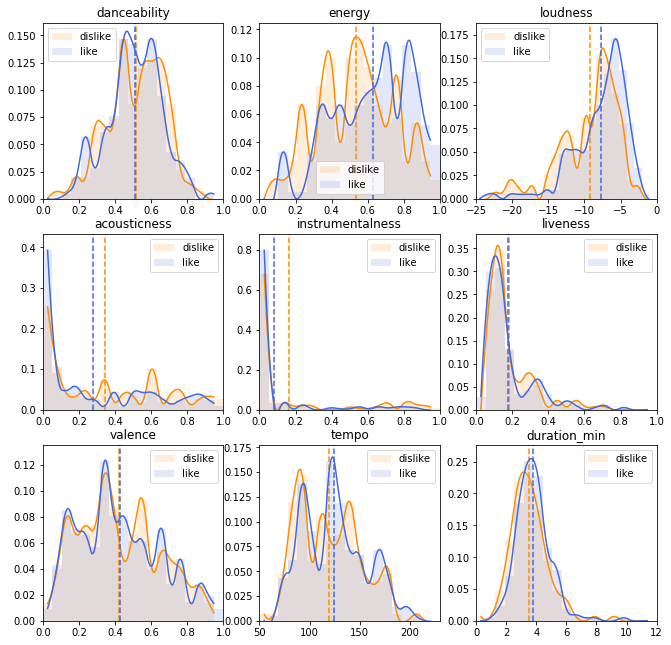

In [214]:
subplotPlot(dislike_df, 'darkorange', 'dislike')
plt.savefig(filepath+'like-dislike.png')

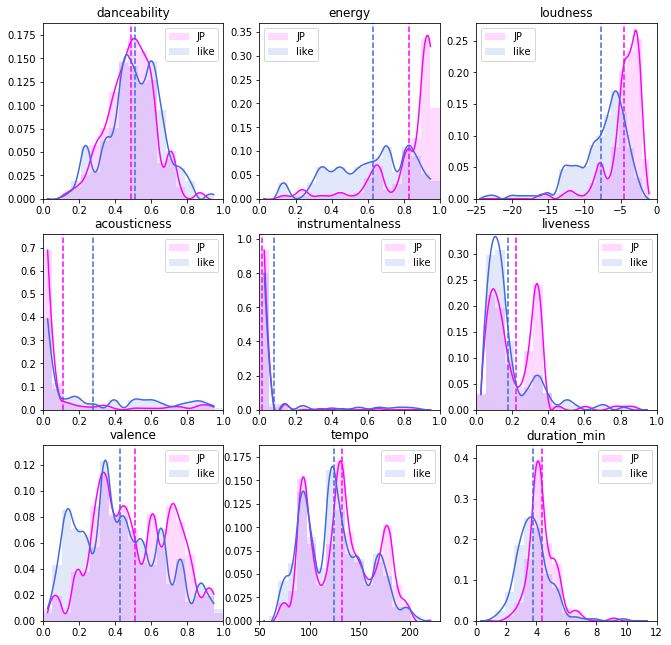

In [112]:
subplotPlot(jp_df, 'magenta', 'JP')
plt.savefig(filepath+'like-JP.png')

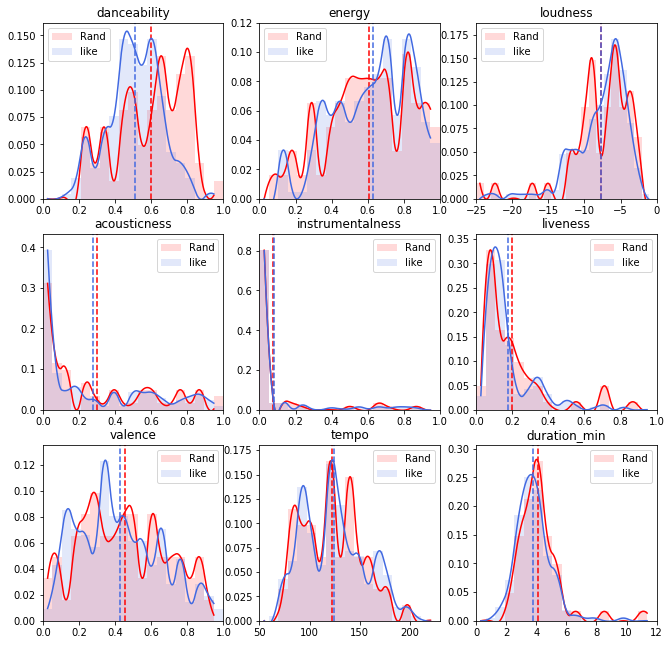

In [113]:
subplotPlot(rand_df, 'red', 'Rand')
plt.savefig(filepath+'like-random.png')

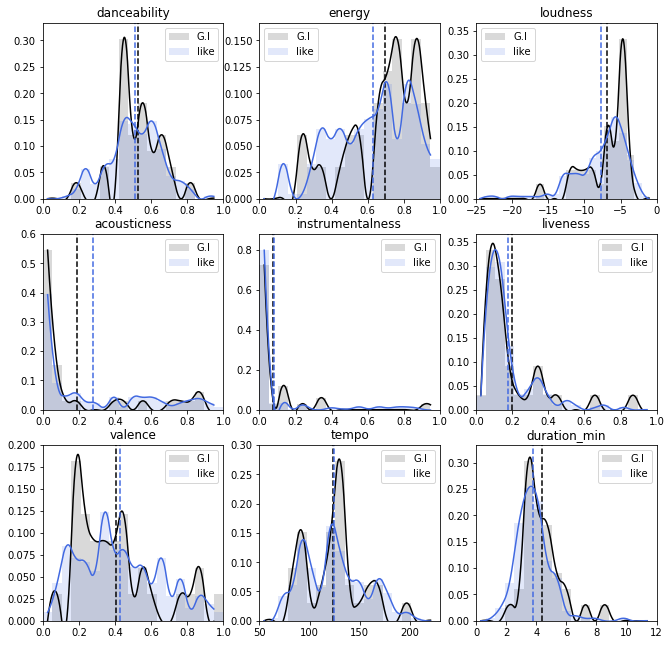

In [114]:
subplotPlot(good_inst_df, 'black', 'G.I')
plt.savefig(filepath+'like-goodinst.png')

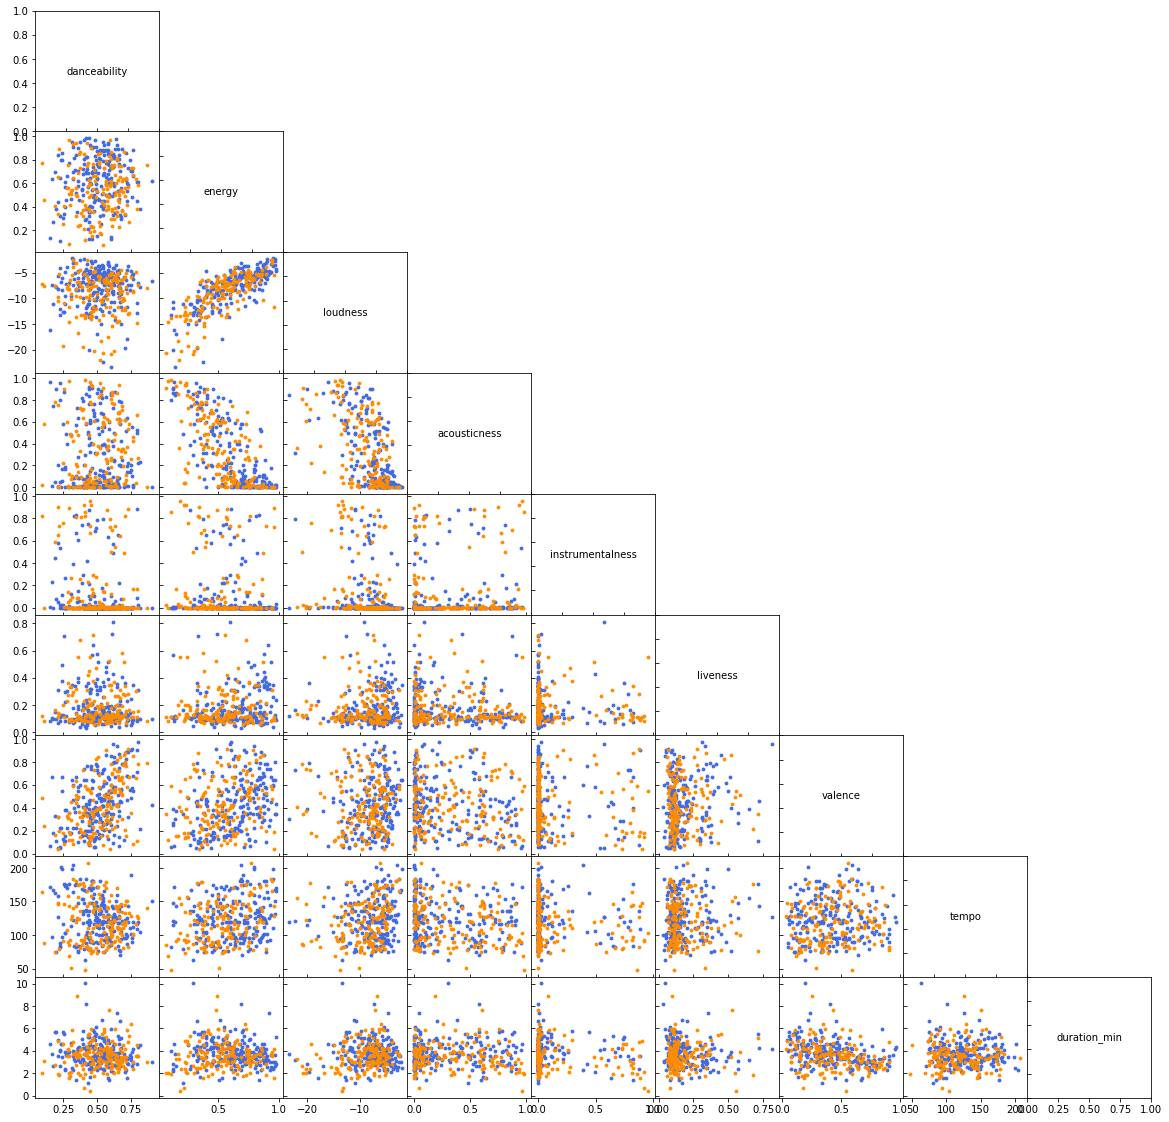

In [115]:
features = ['danceability', 'energy', 'loudness',
           'acousticness', 'instrumentalness', 'liveness',
           'valence', 'tempo', 'duration_min']

plt.figure(figsize = (20, 20))
gs1 = gridspec.GridSpec(len(features), len(features))
gs1.update(wspace=0, hspace=0) 

for i in range(0, len(features)):
    f_y = features[i]
    for j in range(0, len(features)):
        ax = plt.subplot(gs1[i, j])
        f_x = features[j]
        
        if (i < len(features) - 1): 
            ax.tick_params( axis='x', labelbottom = False, labelleft = False, direction = 'in') 
        if (j > 0):
            ax.tick_params( axis='y', labelbottom = False, labelleft = False, direction = 'in') 

        if j == i:
            ax.annotate(f_x, (0.5, 0.5), xycoords='axes fraction', ha='center', va='center')
            continue 
         
        if j > i:
            ax.axis('off')
            continue
            
        ax.scatter(like_df[f_x], like_df[f_y], color = 'royalblue', s = 8)
        ax.scatter(dislike_df[f_x], dislike_df[f_y], color = 'darkorange', s = 8)

plt.savefig(filepath+'feature-matrix.png')

# Machine Learning

In [251]:
import sklearn
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE


In [252]:
def classTrain(clfr, key):
    clfr.fit(X_train, y_train)
    p = clfr.predict(X_test)
    mat = sklearn.metrics.confusion_matrix(y_true = y_test, y_pred = p)
    
    class_dict[key]['matrix'] = mat
    class_dict[key]['acc'] = (mat[0,0] + mat[1, 1]) / sum(sum(mat))
    class_dict[key]['classifier'] = clfr
    
    print(key, class_dict[key]['acc'])

In [253]:
class_dict = {'knn': {'acc': 0, 'classifier': 0, 'matrix': 0},
              'svm-linear': {'acc': 0, 'classifier': 0, 'matrix': 0}, 
              'svm-rbf': {'acc': 0, 'classifier': 0, 'matrix': 0},
              'random-forest': {'acc': 0, 'classifier': 0, 'matrix': 0},
              'logreg': {'acc': 0, 'classifier': 0, 'matrix': 0}
             }

idx = np.random.choice(like_df.shape[0], dislike_df.shape[0], replace = False)

songs_df = pd.concat([like_df.iloc[idx], dislike_df])
X = songs_df.iloc[:,:-1]
X = X.drop(columns=['name', 'key'])
y = songs_df['like']

X = pd.DataFrame(StandardScaler().fit_transform(X), columns = X.keys())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

## PCA

In [269]:
pca = PCA(n_components=len(X.keys()))
principalComponents = pca.fit_transform(X_train)
pca_df = pd.DataFrame(data = principalComponents)
pca_df['like'] = list(y_train)

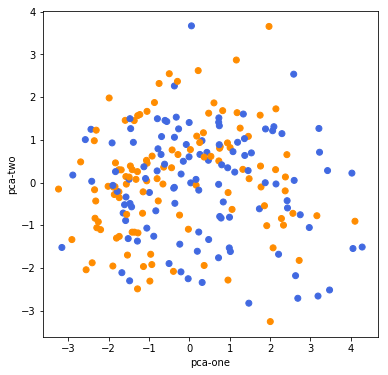

In [276]:
colmap = matplotlib.colors.ListedColormap(['royalblue', 'darkorange'])
plt.subplots(figsize=(6, 6))
plt.scatter(pca_df[0], pca_df[1], c = pca_df['like'], cmap=colmap)
plt.xlabel('pca-one')
plt.ylabel('pca-two')
plt.savefig(filepath+'pca.png')

In [271]:
print(pca.explained_variance_ratio_)
sum(pca.explained_variance_ratio_)

[0.27083584 0.1595256  0.12699736 0.10843467 0.09939973 0.07310336
 0.06574051 0.04225603 0.03790288 0.01580403]


0.9999999999999999

## t-SNE

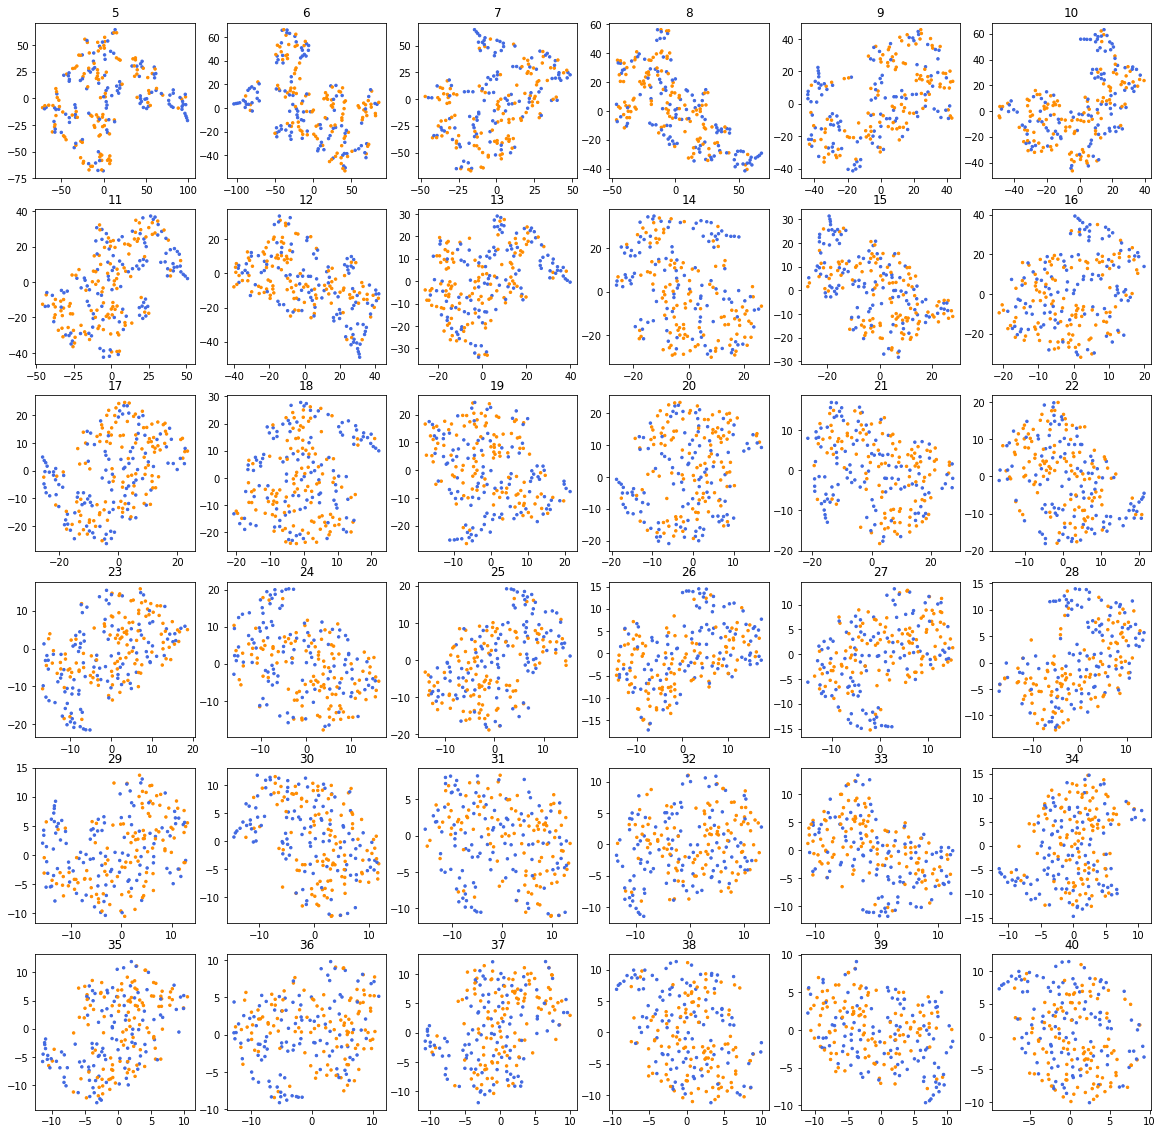

In [272]:
fig, axes = plt.subplots(6, 6, figsize=(20,20))
colmap = matplotlib.colors.ListedColormap(['royalblue', 'darkorange'])

perplex = 5 
for i in range(0, 6):
    for j in range(0, 6):
        tsne = TSNE(n_components=2, verbose=0, perplexity=perplex, n_iter=5000, learning_rate = 10)
        tsne_results = tsne.fit_transform(X_train)

        tsne_df = pd.DataFrame(data = tsne_results, columns = ['tsne1', 'tsne2'])
        tsne_df['like'] = list(y_train)

        axes[i, j].scatter(x=tsne_df['tsne1'], y=tsne_df['tsne2'], c = tsne_df['like'], cmap=colmap, s = 6)
        axes[i, j].set_title(perplex)
        perplex += 1
        
plt.savefig(filepath+'tsne.png')

## k-Nearest Neighbors (kNN)

Evalues k neighbors before assigning a class, usually $k =(n_{row}) ^2$.

In [258]:
classTrain(KNeighborsClassifier(n_neighbors = int(np.floor(X_train.shape[0]**(0.5)))), 'knn')

knn 0.6


## Support Vector Machine (SVM)

SVM draws a hyperplane between points to separate them into classes.

In [259]:
kernels = ["linear", "rbf"]
for i in range(0, len(kernels)):
    classTrain(SVC(kernel=kernels[i]), 'svm-'+kernels[i])

svm-linear 0.6133333333333333
svm-rbf 0.7066666666666667


## Random Forest (RF)

Decision trees, but a lot of them.

In [260]:
classTrain(RandomForestClassifier(n_estimators=1000), "random-forest")

random-forest 0.72


## Logistic Regression (LogReg)

In [261]:
classTrain(LogisticRegression(), 'logreg')

logreg 0.6133333333333333


## Choosing best classifier

In [262]:
max_acc = 0 
max_key = ''

for key in class_dict:
    print(key, class_dict[key]['acc'])
    if class_dict[key]['acc'] > max_acc:
        max_key = key
        max_acc = class_dict[key]['acc']

knn 0.6
svm-linear 0.6133333333333333
svm-rbf 0.7066666666666667
random-forest 0.72
logreg 0.6133333333333333


In [263]:
classifier = class_dict[max_key]['classifier']
print(max_key)
print(pd.DataFrame(class_dict[max_key]['matrix'], columns=['pred. 0', 'pred. 1'], index=['act. 0', 'act. 1']))

random-forest
        pred. 0  pred. 1
act. 0       29        9
act. 1       12       25


# Predictive Datasets

In [264]:
def predictor(df, classifier, flag):
    names = df['name']
    df = df.drop(columns=['name'])
    p = classifier.predict(df)
    if (not flag):
        print("accuracy: ", sum(p) / len(p))
    print("labeled dislike:")
    print(names[p == 0])
    if (flag):
        print("labeled like:")
        print(names[p == 1])
    return p

In [265]:
p_jp = predictor(jp_df.drop(columns=['key']), classifier, False)

accuracy:  0.5569620253164557
labeled dislike:
4                                              光
5                       Passion - Single Version
6                               Prisoner Of Love
10                               Yukei Yesterday
14                                         Magia
16                                    Starrrrrrr
17                         Namae No Nai Kaibutsu
18                  The Everlasting Guilty Crown
19                                   Ideal White
21                          Yoru Wa Nemurerukai?
25                                     Träumerei
27                                      Re: I Am
28                                 Last Stardust
29                                  Insane Dream
31                                   White Light
35                                 Bloody Stream
38                                         Stars
39                                     Innocence
43                              Wherever you are
44                    

In [267]:
p_gi = predictor(good_inst_df.drop(columns=['key']), classifier, False)

accuracy:  0.5151515151515151
labeled dislike:
2                               Can’t Let Go, Juno
3                                          Clarity
4                               Another Day Of Sun
6                                        Innocence
7                                            Stars
11    Details in the Fabric (feat. James Morrison)
13                         Changing Of The Seasons
18                                     A L I E N S
19                                         Fluquor
20                                   Last Stardust
22                                     Life Itself
23                                       100 Years
25                         Changing Of The Seasons
28                                  The Golden Age
29                                    Dirty Summer
32                                 Death Stranding
Name: name, dtype: object


In [268]:
p_rand = predictor(rand_df.drop(columns=['key']), classifier, True)

labeled dislike:
4       Cha Cha Slide - Original Live Platinum Band Mix
5                                           Truth Hurts
6                                             Papa Hobo
8                (You'll Have to Swing It) Mr. Paganini
13                                            Last Leaf
15                                                  HIP
16                    Afterhours feat. Diplo & Nina Sky
18                            Remember Me (From "Coco")
23                                      Ni**as In Paris
26                                    Send Me On My Way
28                                                  DHL
31                                 Wanted Dead Or Alive
32                                    Carry Your Throne
33                                             无羁 - 器乐版
40                                    Social Disability
44                                               Blanco
47    Piano Sonata No. 6 in A Major, Op. 82: 1. Alle...
50                             